In [48]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16 , ResNet50 , InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# model.add(layers.Dense(64, activation=opt))
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

def prepare_image_list(folder, img_width, img_height, class_names):
    image_list = []
    image_labels = []
    for folder_name in os.listdir(folder):
        full_folder_path = os.path.join(folder, folder_name)
        for img_name in os.listdir(full_folder_path):
            img_path = os.path.join(full_folder_path, img_name)
            img = image.load_img(img_path, target_size=(img_width, img_height))
            img = image.img_to_array(img)
            img = preprocess_input(img)
            image_list.append(img)
            image_labels.append(class_names.index(folder_name))
    return np.array(image_list), to_categorical(image_labels)



In [51]:
# Define paths
base_path = "C:/cnndata"
train_folder = os.path.join(base_path, "train")
test_folder = os.path.join(base_path, "test")
validation_folder = os.path.join(base_path, "validation")


In [52]:
# Image dimensions
img_width=150
img_height=150
#variables for image size
img_size = (150, 150)

# Model parameters
batch_size = 64
epochs = 5

In [53]:
# List class names
train_class_names = os.listdir(train_folder)
test_class_names = os.listdir(test_folder)
val_class_names = os.listdir(validation_folder)

print("train_class_names:", train_class_names)
print("test_class_names:", test_class_names)
print("val_class_names:", val_class_names)

train_class_names: ['covid', 'normal', 'pneumonia']
test_class_names: ['covidtest', 'normaltest', 'pneumoniatest']
val_class_names: ['covidvalid', 'normalvalid', 'pneumoniavalid']


In [54]:
# Prepare datasets
x_train, y_train = prepare_image_list(train_folder, img_width, img_height, train_class_names)
x_test, y_test = prepare_image_list(test_folder, img_width, img_height, test_class_names)
x_val, y_val = prepare_image_list(validation_folder, img_width, img_height, val_class_names)

print("Training Dataset:", x_train.shape, y_train.shape)
print("Test Dataset:", x_test.shape, y_test.shape)
print("Validation Dataset:", x_val.shape, y_val.shape)


Training Dataset: (3075, 150, 150, 3) (3075, 3)
Test Dataset: (750, 150, 150, 3) (750, 3)
Validation Dataset: (750, 150, 150, 3) (750, 3)


In [55]:
#model creation
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [56]:
#model training 
base_models = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,)),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False, input_shape=img_size + (3,))
}

results = {}
for name, base_model in base_models.items():
    print(f"Training {name}...")
    with tf.device('/device:GPU:0'):
        model = create_model(base_model, len(train_class_names))
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=True)
        results[name] = history.history


Training VGG16...
Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 753s 15s/step - accuracy: 0.7001 - loss: 0.9094 - val_accuracy: 0.8440 - val_loss: 0.5316
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 757s 16s/step - accuracy: 0.8938 - loss: 0.3061 - val_accuracy: 0.8573 - val_loss: 0.4075
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 753s 15s/step - accuracy: 0.9284 - loss: 0.2079 - val_accuracy: 0.8693 - val_loss: 0.4234
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 733s 15s/step - accuracy: 0.9417 - loss: 0.1803 - val_accuracy: 0.8693 - val_loss: 0.4391
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 720s 15s/step - accuracy: 0.9551 - loss: 0.1436 - val_accuracy: 0.8720 - val_loss: 0.4175
Training ResNet50...
Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - accuracy: 0.7449 - loss: 0.6015 - val_accuracy: 0.8693 - val_loss: 0.3799
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.9165 - loss: 0.2318 - val_accuracy: 0.9080 - val_loss: 0.2895
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 234s 5s/step - accuracy: 0.9397 - los

In [65]:
print("\nValidation Set Results:") #seeing validation values 
for name, metrics in results.items():
    print(f"{name}: Loss = {metrics['loss']}, Accuracy = {metrics['accuracy']}")


Validation Set Results:
VGG16: Loss = [0.63181471824646, 0.3021474778652191, 0.20401893556118011, 0.1740211546421051, 0.14932715892791748], Accuracy = [0.7947967648506165, 0.896260142326355, 0.9307317137718201, 0.9427642226219177, 0.9495934844017029]
ResNet50: Loss = [0.41055041551589966, 0.2191169708967209, 0.17674663662910461, 0.1435779333114624, 0.13943472504615784], Accuracy = [0.8426015973091125, 0.9242276549339294, 0.9401625990867615, 0.9525203108787537, 0.9531707167625427]
InceptionV3: Loss = [4.494155406951904, 1.7695311307907104, 1.1109676361083984, 0.8907936215400696, 0.8537722826004028], Accuracy = [0.7154471278190613, 0.7947967648506165, 0.8452032804489136, 0.8637398481369019, 0.8692682981491089]


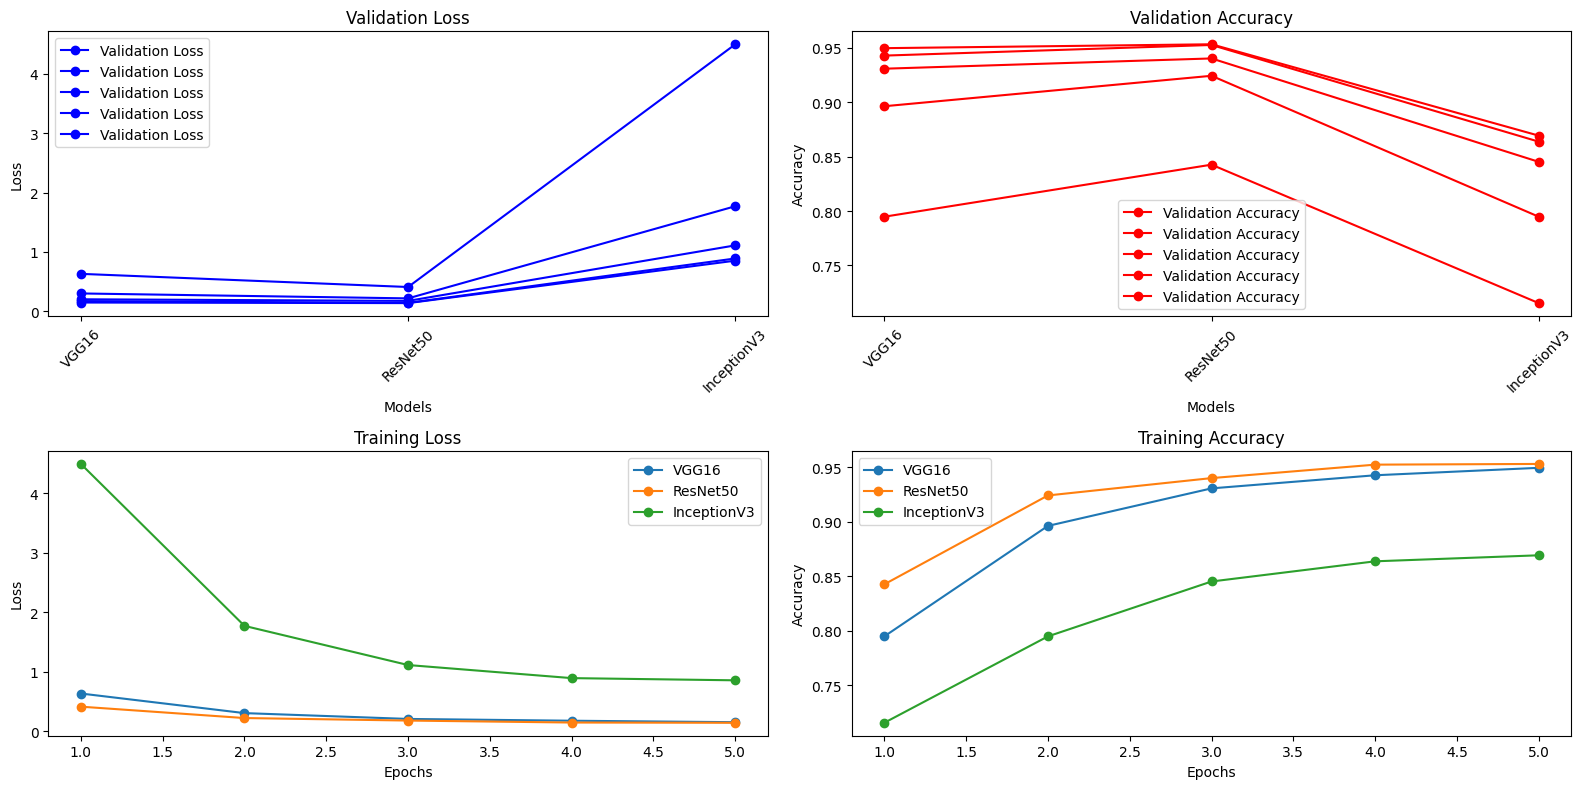

In [105]:
import matplotlib.pyplot as plt

# Validation set results
val_losses = [results[model]['loss'] for model in base_models]
val_accuracies = [results[model]['accuracy'] for model in base_models]
model_names = list(base_models.keys())

# Plotting
plt.figure(figsize=(16, 8))

# Plot 1: Validation Loss
plt.subplot(2, 2, 1)
plt.plot(model_names, val_losses, marker='o', color='b', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.xticks(rotation=45)
plt.legend()

# Plot 2: Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(model_names, val_accuracies, marker='o', color='r', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend()

# Track training history
train_losses = {}
train_accuracies = {}

for name, history in results.items():
    train_losses[name] = history['loss']
    train_accuracies[name] = history['accuracy']

# Plot 3: Training Loss vs. Epochs
plt.subplot(2, 2, 3)
for name, loss in train_losses.items():
    plt.plot(range(1, epochs + 1), loss, marker='o', label=name)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 4: Training Accuracy vs. Epochs
plt.subplot(2, 2, 4)
for name, accuracy in train_accuracies.items():
    plt.plot(range(1, epochs + 1), accuracy, marker='o', label=name)
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [97]:
# Save the model
model_Xrays = os.path.join(base_path, f"{name}_model.h5")
model.save(model_Xrays)
print(f"Model {name} saved at {model_Xrays}")

Model InceptionV3 saved at C:/cnndata\InceptionV3_model.h5


In [98]:
# Load models for testing
loaded_models = {}
for name in base_models.keys():
    model_path = os.path.join(base_path, f"{name}_model.h5")
    loaded_models[name] = tf.keras.models.load_model(model_path)

In [119]:
def predict_single_image(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(img_array)
    img_expanded = np.expand_dims(img_preprocessed, axis=0)
    prediction = model.predict(img_expanded)
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class, img_array

Testing covidtest...
Image: COVID19(100).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


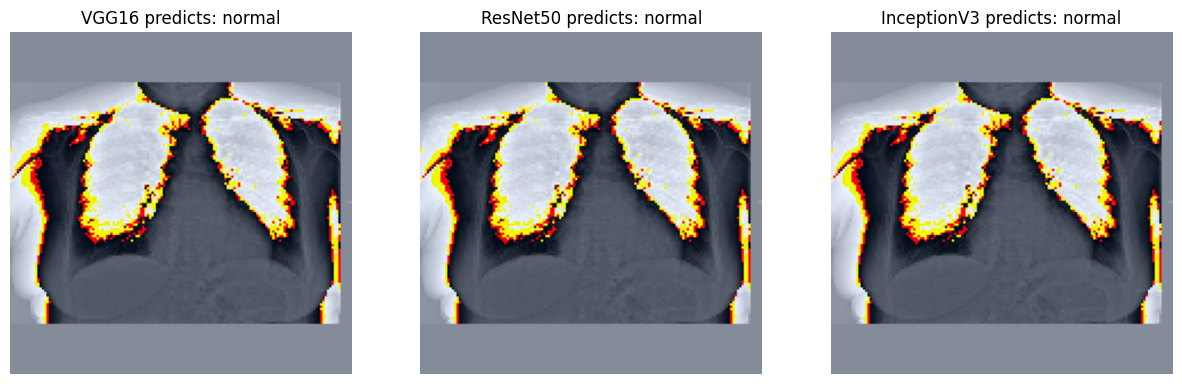

Image: COVID19(101).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


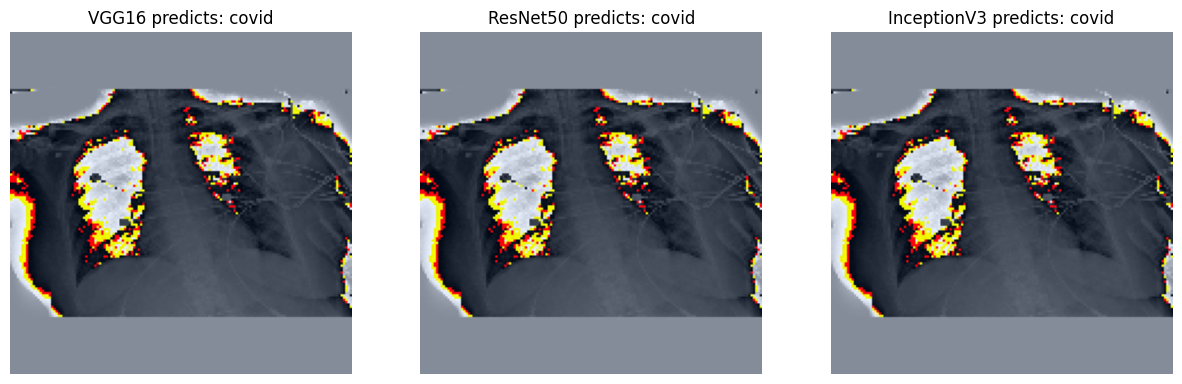

Image: COVID19(102).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


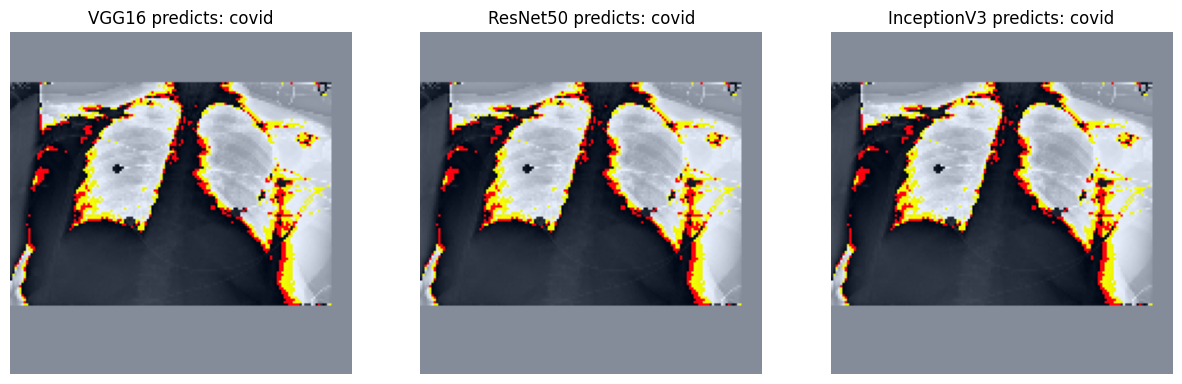

Image: COVID19(103).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


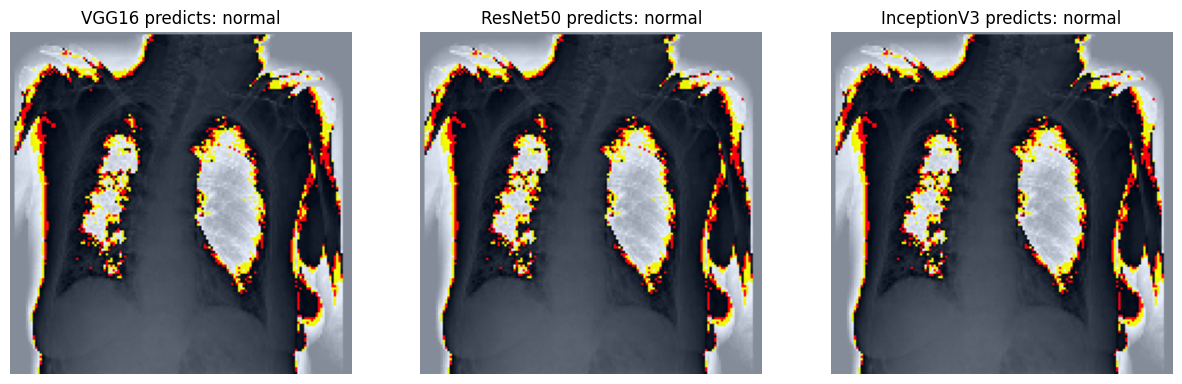

Image: COVID19(104).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


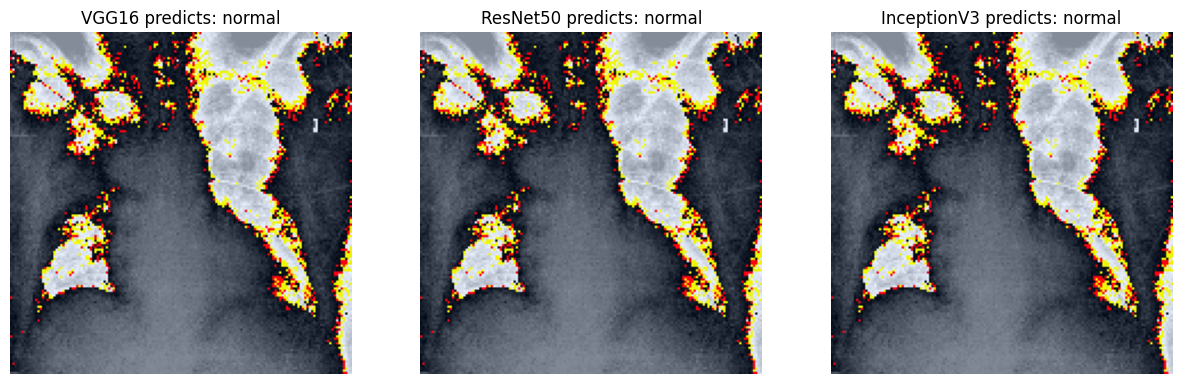

Testing normaltest...
Image: 00000715_001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


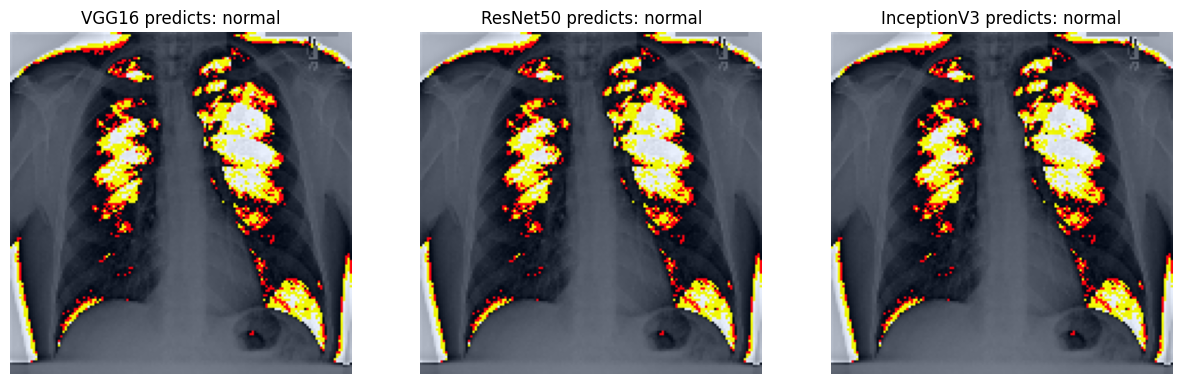

Image: 00000716_001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


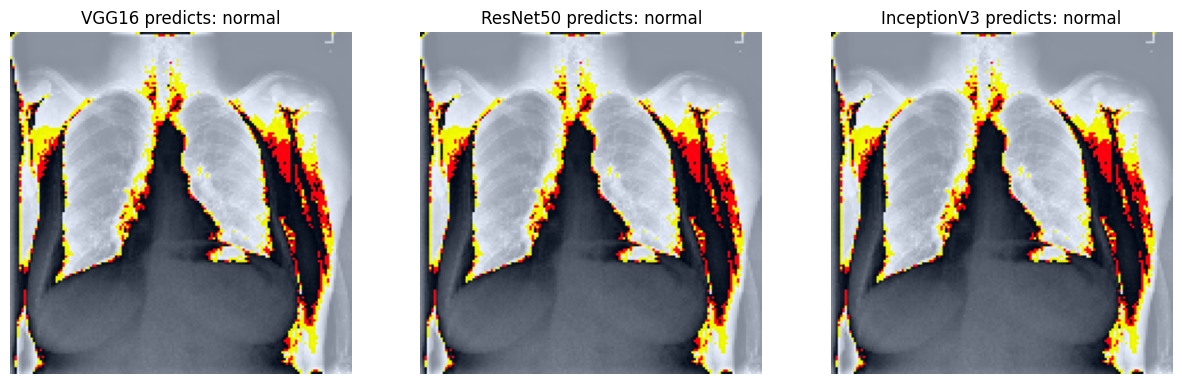

Image: 00000716_002.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


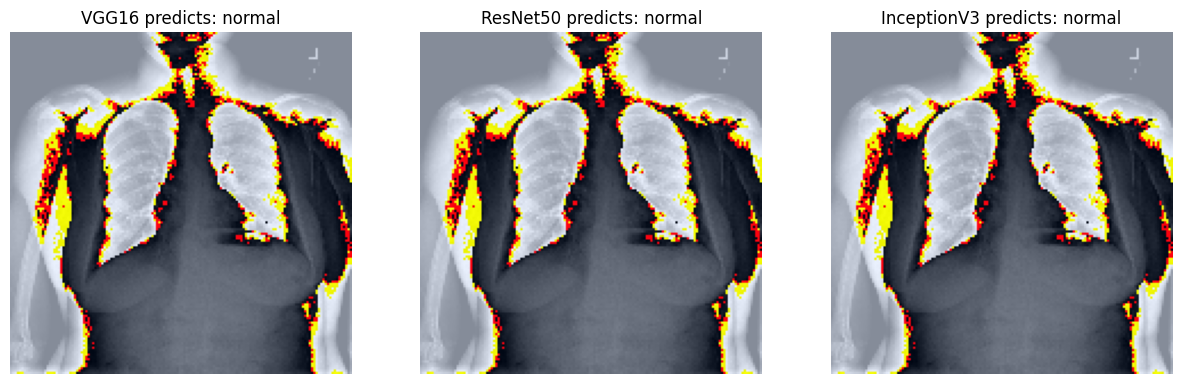

Image: 00000716_003.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


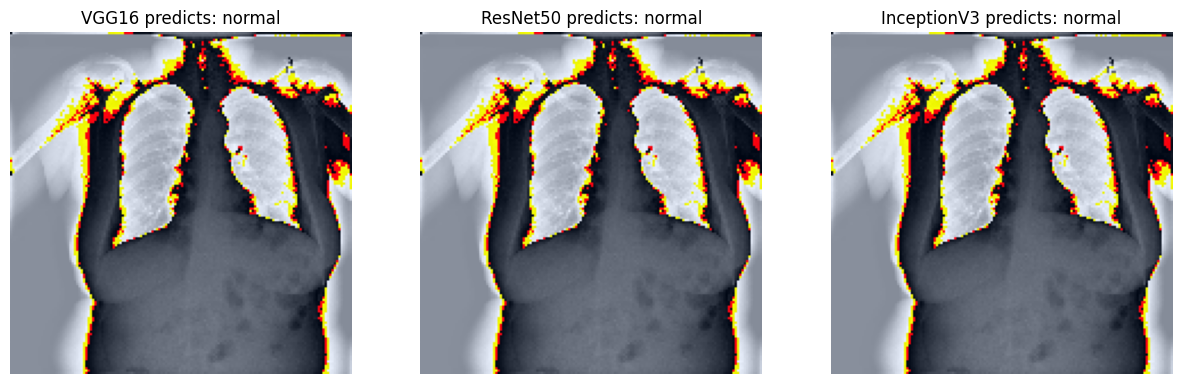

Image: 00000717_000.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


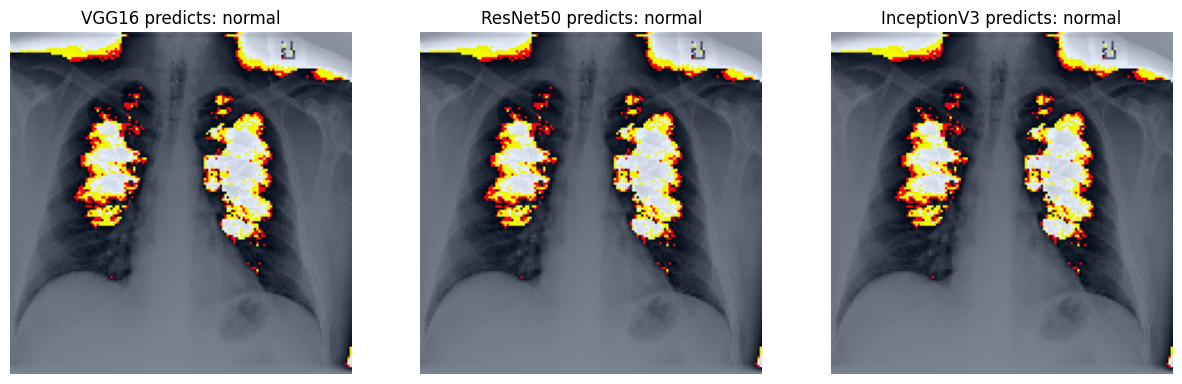

Testing pneumoniatest...
Image: person1034_bacteria_2968.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


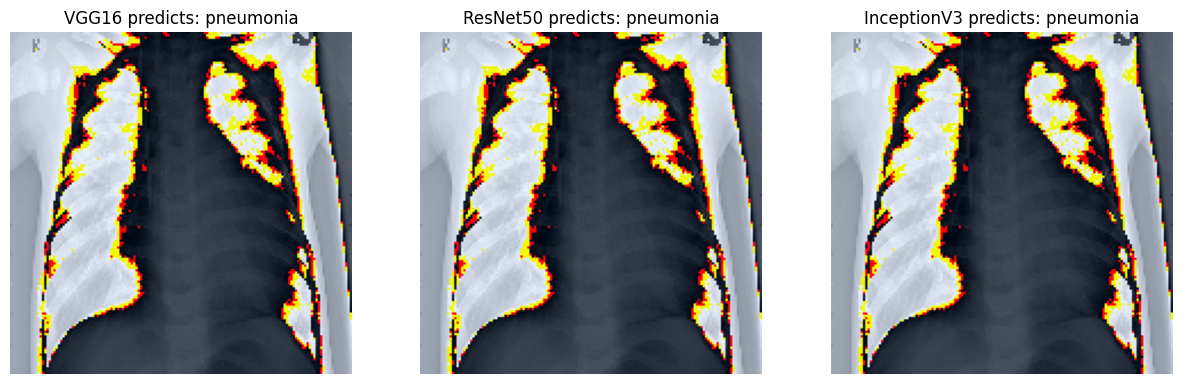

Image: person1035_bacteria_2969.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


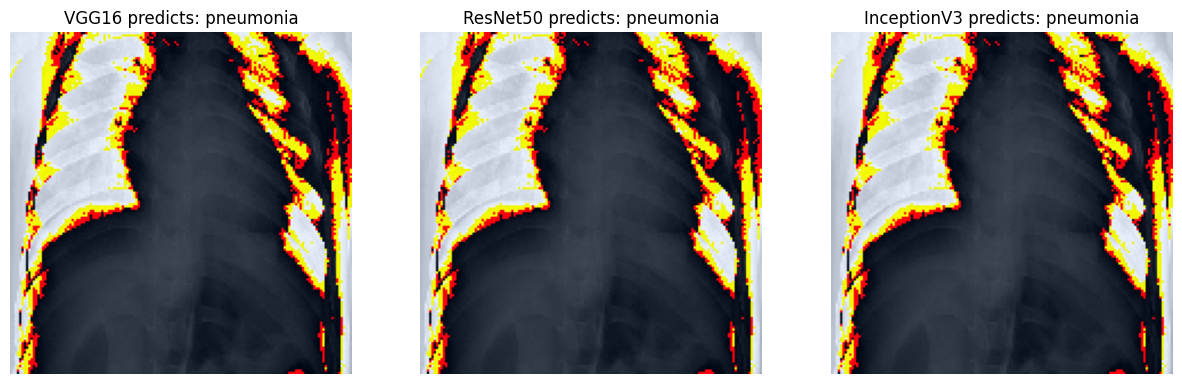

Image: person1036_bacteria_2970.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


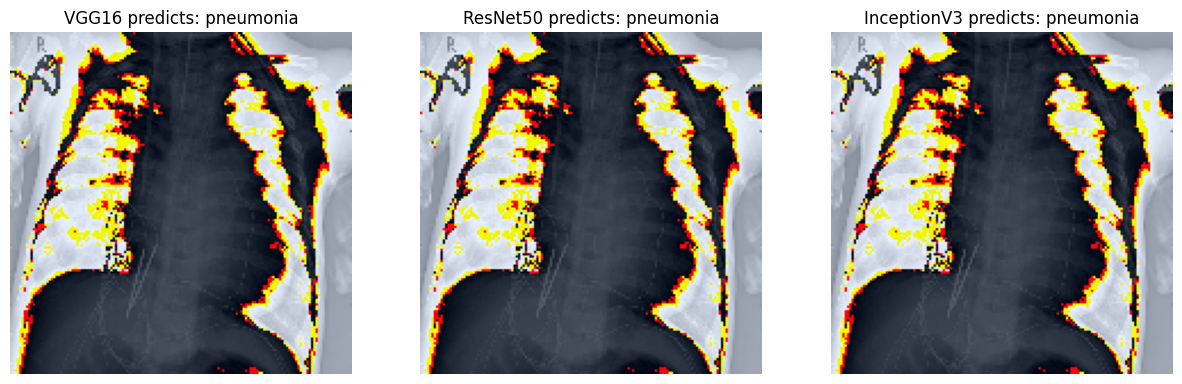

Image: person1038_bacteria_2972.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


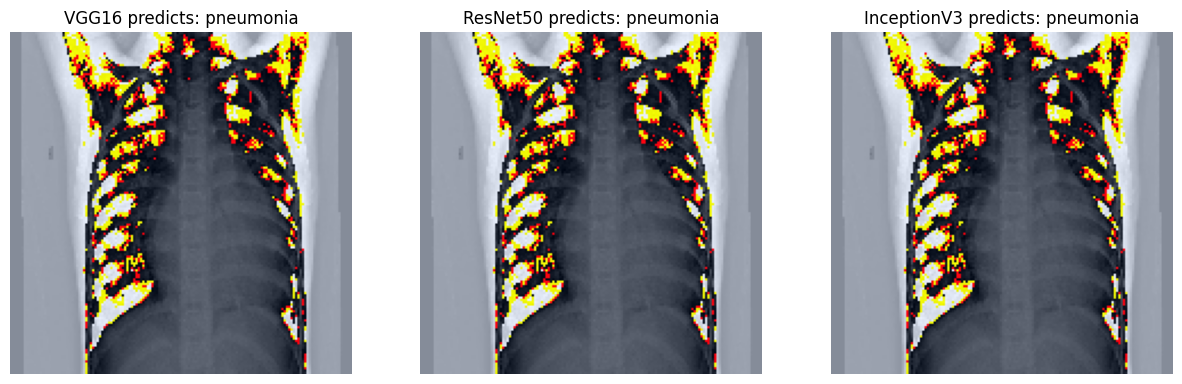

Image: person1042_virus_1737.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


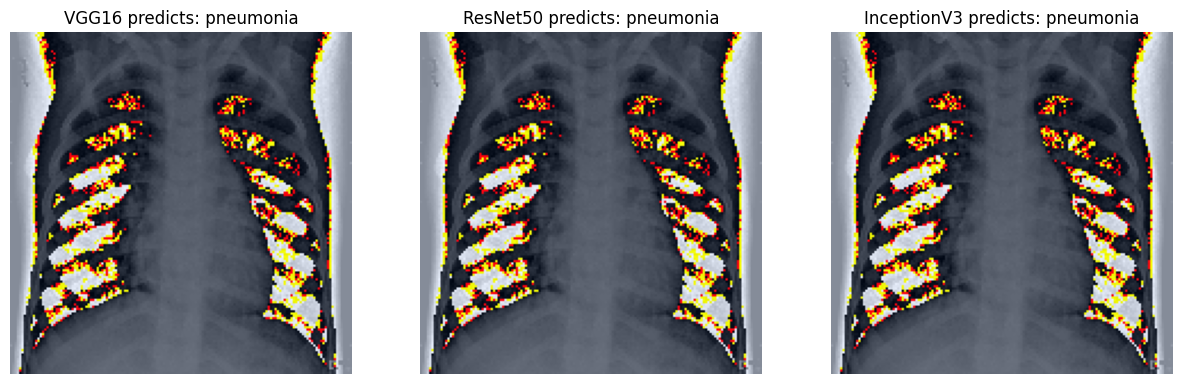

In [123]:
for class_name in test_class_names:
    print(f"Testing {class_name}...")
    class_folder = os.path.join(test_folder, class_name)
    class_images = os.listdir(class_folder)[:5]
    for img_name in class_images:
        img_path = os.path.join(class_folder, img_name)
        print(f"Image: {img_name}")
        plt.figure(figsize=(15, 5))
        for i, (name, model) in enumerate(loaded_models.items()):
            predicted_class, img_array = predict_single_image(model, img_path, train_class_names)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img_array.astype('uint8'))
            plt.title(f"{name} predicts: {predicted_class}")
            plt.axis('off')
        plt.show()